In [21]:
# Cài đặt/cập nhật các thư viện cần thiết bằng pip thông qua Python
# Mục tiêu: đảm bảo môi trường có đủ gói để chạy bài tập xử lý ảnh (numpy, opencv, tensorflow/keras, sklearn, matplotlib,...).
import importlib
import subprocess
import sys

# Danh sách các thư viện cần cài
packages = [
    "numpy",
    "pickle-mixin",   # pickle là thư viện chuẩn, nhưng một số môi trường cần gói mở rộng
    "opencv-python",
    "scikit-learn",
    "keras",
    "tensorflow",     # cần cho keras
    "matplotlib"
]

# Hàm cài đặt nếu chưa có
def install_if_missing(package):
    try:
        importlib.import_module(package.split('-')[0])
        print(f"✅ {package} đã được cài đặt.")
    except ImportError:
        print(f"📦 Đang cài đặt {package} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Cài đặt lần lượt từng thư viện
for pkg in packages:
    install_if_missing(pkg)

print("\n🎉 Hoàn tất cài đặt tất cả thư viện cần thiết!")


✅ numpy đã được cài đặt.
✅ pickle-mixin đã được cài đặt.
📦 Đang cài đặt opencv-python ...
📦 Đang cài đặt scikit-learn ...
✅ keras đã được cài đặt.
✅ tensorflow đã được cài đặt.
✅ matplotlib đã được cài đặt.

🎉 Hoàn tất cài đặt tất cả thư viện cần thiết!


In [22]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt


In [23]:
EPOCHS = 50
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = r'D:\PTIT\XLA\PlantVillage'
# Giới hạn số ảnh mỗi lớp (None = dùng tất cả)
MAX_IMAGES_PER_CLASS = None
# Seed tái lập
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
width=256
height=256
depth=3

In [24]:
import os  # dùng cho kiểm tra/thao tác đường dẫn


In [25]:
# Dùng generator để không load toàn bộ ảnh vào RAM
USE_GENERATOR = True

if USE_GENERATOR:
    gen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=25,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    train_gen = gen.flow_from_directory(
        directory_root,
        target_size=(height, width),
        batch_size=BS,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )
    val_gen = gen.flow_from_directory(
        directory_root,
        target_size=(height, width),
        batch_size=BS,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )
    n_classes = train_gen.num_classes


Found 33027 images belonging to 16 classes.
Found 8249 images belonging to 16 classes.


In [26]:
def convert_image_to_array(image_dir):
    try:
        # Đọc ảnh robust (hỗ trợ đường dẫn Unicode trên Windows)
        image = cv2.imdecode(np.fromfile(image_dir, dtype=np.uint8), cv2.IMREAD_COLOR)
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [27]:
image_list, label_list = [], []
try:
    if 'USE_GENERATOR' in globals() and USE_GENERATOR:
        print("[INFO] USE_GENERATOR=True → Bỏ qua bước load ảnh thủ công.")
    else:
        if not os.path.isdir(directory_root):
            raise FileNotFoundError(f"Dataset folder not found: {directory_root}. Hãy cập nhật biến `directory_root` tới thư mục dữ liệu trên máy bạn.")

        print("[INFO] Loading images ...")
        lvl1_folders = [d for d in listdir(directory_root) if d != ".DS_Store" and os.path.isdir(os.path.join(directory_root, d))]

        for lvl1 in lvl1_folders:
            path_lvl1 = os.path.join(directory_root, lvl1)
            lvl2_folders = [d for d in listdir(path_lvl1) if d != ".DS_Store" and os.path.isdir(os.path.join(path_lvl1, d))]

            # Nếu có thư mục con cấp 2: coi cấp 2 là lớp (hợp với dataset 2-level)
            if len(lvl2_folders) > 0:
                for cls in lvl2_folders:
                    class_dir = os.path.join(path_lvl1, cls)
                    print(f"[INFO] Processing {cls} ...")
                    count = 0
                    for fname in listdir(class_dir):
                        if fname == ".DS_Store":
                            continue
                        name_l = fname.lower()
                        if name_l.endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")):
                            image_path = os.path.join(class_dir, fname)
                            image_list.append(convert_image_to_array(image_path))
                            label_list.append(cls)
                            count += 1
                            if MAX_IMAGES_PER_CLASS is not None and count >= MAX_IMAGES_PER_CLASS:
                                break
            # Nếu không có thư mục con: coi cấp 1 là lớp (hợp với PlantVillage 1-level)
            else:
                print(f"[INFO] Processing {lvl1} ...")
                count = 0
                for fname in listdir(path_lvl1):
                    if fname == ".DS_Store":
                        continue
                    name_l = fname.lower()
                    if name_l.endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")):
                        image_path = os.path.join(path_lvl1, fname)
                        image_list.append(convert_image_to_array(image_path))
                        label_list.append(lvl1)
                        count += 1
                        if MAX_IMAGES_PER_CLASS is not None and count >= MAX_IMAGES_PER_CLASS:
                            break

        print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] USE_GENERATOR=True → Bỏ qua bước load ảnh thủ công.


In [28]:
image_size = len(image_list)

In [29]:
if 'USE_GENERATOR' in globals() and USE_GENERATOR:
    # Lưu danh sách lớp theo đúng thứ tự index của generator
    idx_map = train_gen.class_indices  # dict: class_name -> index
    class_names = [None] * len(idx_map)
    for name, idx in idx_map.items():
        class_names[idx] = name
    pickle.dump(class_names, open('label_transform.pkl', 'wb'))
    n_classes = len(class_names)
else:
    label_binarizer = LabelBinarizer()
    image_labels = label_binarizer.fit_transform(label_list)
    pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
    n_classes = len(label_binarizer.classes_)

In [30]:
if 'USE_GENERATOR' in globals() and USE_GENERATOR:
    print(class_names)
else:
    print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'PlantVillage', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [31]:
if not ('USE_GENERATOR' in globals() and USE_GENERATOR):
    np_image_list = np.array(image_list, dtype=np.float32) / 255.0


In [32]:
if not ('USE_GENERATOR' in globals() and USE_GENERATOR):
    print("[INFO] Spliting data to train, test")
    x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

In [33]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [34]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1

# Khai báo Input để tránh warning và rõ ràng kiến trúc
model.add(Input(shape=inputShape))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [35]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 85, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 85, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 85, 85, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 85, 85, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 85, 85, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 85, 85, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 85, 85, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 85, 85, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 42, 42, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 42, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 42, 42, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 42, 42, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 42, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 42, 42, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 56448)          │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 58,103,696 (221.65 MB)

 Trainable params: 58,100,816 (221.64 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [36]:
opt = Adam(learning_rate=INIT_LR)
loss_fn = "binary_crossentropy" if n_classes == 2 else "categorical_crossentropy"
model.compile(loss=loss_fn, optimizer=opt, metrics=["accuracy"])
print("[INFO] training network...")

[INFO] training network...


In [37]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

if 'USE_GENERATOR' in globals() and USE_GENERATOR:
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )
else:
    history = model.fit(
        aug.flow(x_train, y_train, batch_size=BS, shuffle=True),
        validation_data=(x_test, y_test),
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )  

Epoch 1/50
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 2872s 3s/step - accuracy: 0.4353 - loss: 1.7317 - val_accuracy: 0.3134 - val_loss: 2.0811 - learning_rate: 0.0010
Epoch 2/50
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 2816s 3s/step - accuracy: 0.5026 - loss: 1.2409 - val_accuracy: 0.2560 - val_loss: 2.2068 - learning_rate: 0.0010
Epoch 3/50
 947/1033 ━━━━━━━━━━━━━━━━━━━━ 3:41 3s/step - accuracy: 0.5154 - loss: 1.1453

KeyboardInterrupt: 

In [ ]:
import os
model_path = 'best_model.keras' if os.path.exists('best_model.keras') else 'cnn_model.keras'
model_f = load_model(model_path)

In [ ]:
import os
model_path = 'best_model.keras' if os.path.exists('best_model.keras') else 'cnn_model.keras'
model_f = load_model(model_path)

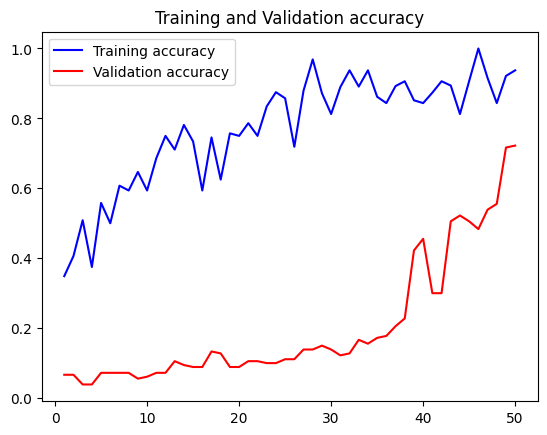

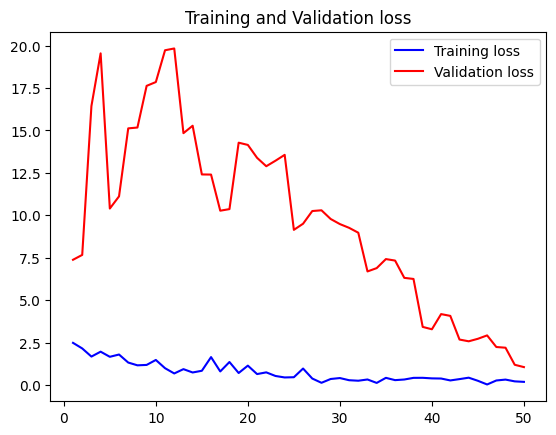

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
if 'USE_GENERATOR' in globals() and USE_GENERATOR:
    scores = model.evaluate(val_gen)
else:
    scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 393ms/step - accuracy: 0.7222 - loss: 1.0573
Test Accuracy: 72.22222089767456


In [ ]:
# save the model to disk
print("[INFO] Saving model...")
model.save('cnn_model.keras')

[INFO] Saving model...


In [ ]:
import os
model_path = 'best_model.keras' if os.path.exists('best_model.keras') else 'cnn_model.keras'
model_f = load_model(model_path)

In [ ]:
# Đường dẫn ảnh test trên máy bạn (cập nhật lại cho phù hợp)
import os, pickle

test_image_path = r'D:\\path\\to\\your\\test.jpg'

if not os.path.exists(test_image_path):
    raise FileNotFoundError(f"Không tìm thấy ảnh: {test_image_path}")

# Đọc ảnh robust (hỗ trợ đường dẫn Unicode)
pic = cv2.imdecode(np.fromfile(test_image_path, dtype=np.uint8), cv2.IMREAD_COLOR)
if pic is None:
    raise ValueError("Không đọc được ảnh. Kiểm tra lại đường dẫn/định dạng file.")

pic = cv2.resize(pic, (256, 256))
pic = pic.astype('float32') / 255.0
pic = np.expand_dims(pic, axis=0)

y_prob = model_f.predict(pic)
y_classes = y_prob.argmax(axis=-1)
print('Predicted index:', y_classes)

# In ra tên lớp dự đoán
obj = pickle.load(open('label_transform.pkl','rb'))
if hasattr(obj, 'classes_'):
    class_names = obj.classes_
elif isinstance(obj, (list, tuple)):
    class_names = obj
else:
    raise ValueError('label_transform.pkl không đúng định dạng mong muốn')
print('Predicted label:', class_names[int(y_classes[0])])

FileNotFoundError: Không tìm thấy ảnh: D:\\path\\to\\your\\test.jpg